### 1. Data Loading

Load historical financial data for a specified stock ticker and date range using the `yfinance` library.

In [8]:
!pip install yfinance scikit-learn tensorflow

import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Define the stock ticker and date range
ticker = "AAPL"
start_date = "2010-01-01"
end_date = "2023-01-01"

# Download the data
data = yf.download(ticker, start=start_date, end=end_date)

display(data.head())

/tmp/ipython-input-8-2550979766.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431895,6.446622,6.382907,6.414464,493729600
2010-01-05,6.443017,6.479383,6.409055,6.449629,601904800
2010-01-06,6.340532,6.468563,6.333920,6.443017,552160000
2010-01-07,6.328810,6.371488,6.282827,6.363974,477131200
2010-01-08,6.370886,6.371487,6.283128,6.320395,447610800


### 2. Feature Engineering

Engineer features suitable for time series forecasting with LSTM. For this example, we will use the 'Close' price as the main feature and the target variable.

In [9]:
# Use 'Close' price as the feature
data = data[['Close']]

display(data.head())

Price,Close
Ticker,AAPL
Date,
2010-01-04,6.431895
2010-01-05,6.443017
2010-01-06,6.340532
2010-01-07,6.328810
2010-01-08,6.370886


### 3. Data Preprocessing for LSTM

Prepare the data for LSTM input by scaling the features and structuring the data into sequences.

In [10]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 60 # Number of past days to consider for prediction
X, y = create_sequences(scaled_data, sequence_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2569, 60, 1)
Shape of y_train: (2569,)
Shape of X_test: (643, 60, 1)
Shape of y_test: (643,)


### 4. Build and Compile LSTM Model

Define and compile an LSTM model using TensorFlow.

In [11]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

### 5. Train LSTM Model

Train the compiled LSTM model on the prepared training data.

In [12]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - loss: 0.0025 - val_loss: 4.2589e-04
Epoch 2/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 4.8537e-05 - val_loss: 3.7622e-04
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 5.4900e-05 - val_loss: 3.3603e-04
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 5.4394e-05 - val_loss: 3.2919e-04
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 4.2977e-05 - val_loss: 4.8976e-04
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 3.8042e-05 - val_loss: 3.1965e-04
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 3.4469e-05 - val_loss: 2.4622e-04
Epoch 8/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 2.7195e-05 - val_loss: 3.9179e-04
Epoch 9/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 3.1238e-05 - val_loss: 2.9576e-04
Epoch 10/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 3.3839e-05 - val_loss: 2.7150e-04
Epoch 11/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 2.6424e-05 

### 6. Evaluate LSTM Model

Evaluate the trained LSTM model's performance on the test data using relevant time series forecasting metrics.

In [13]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
mse = mean_squared_error(y_test_original, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Mean Squared Error (MSE): 56.22031509454141
Root Mean Squared Error (RMSE): 7.49802074513944
Mean Absolute Error (MAE): 6.289549108241246


### 7. Visualize Predictions

Plot the LSTM model's predictions against the actual historical stock prices on the test set.

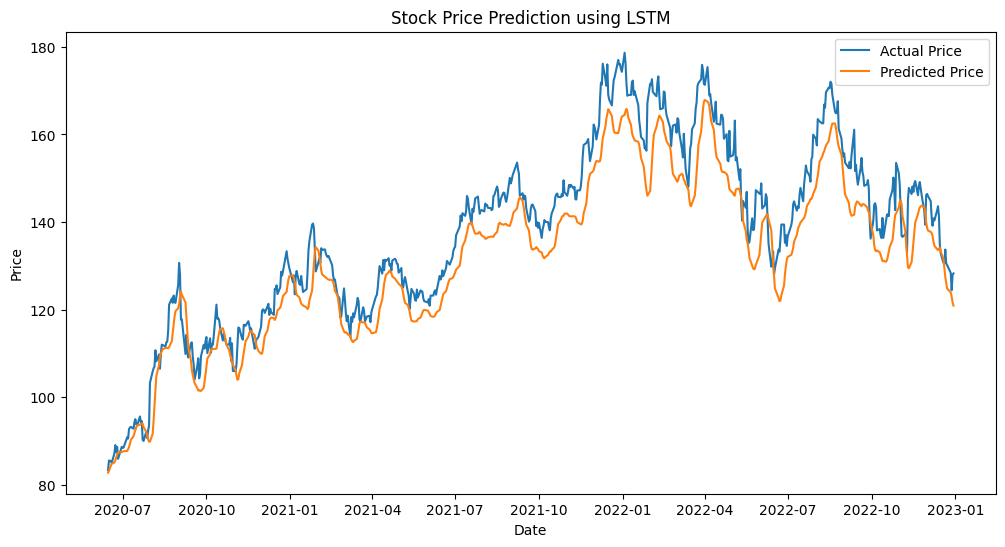

In [14]:
# Create a date index for the test predictions
test_data_index = data.tail(len(y_test_original)).index

plt.figure(figsize=(12, 6))
plt.plot(test_data_index, y_test_original, label="Actual Price")
plt.plot(test_data_index, predictions, label="Predicted Price")
plt.title("Stock Price Prediction using LSTM")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

### 8. Explore GRU Model

Implement and train a Gated Recurrent Unit (GRU) model as an alternative to the LSTM model. GRUs are similar to LSTMs but with a simpler architecture, which can sometimes lead to faster training and comparable performance.

In [15]:
from tensorflow.keras.layers import GRU

# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
gru_model.add(GRU(units=50))
gru_model.add(Dense(units=1))

# Compile the GRU model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
print("Training GRU model...")
gru_history = gru_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

# Evaluate the GRU model
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)
gru_mse = mean_squared_error(y_test_original, gru_predictions)
gru_rmse = np.sqrt(gru_mse)
gru_mae = mean_absolute_error(y_test_original, gru_predictions)

print("\nGRU Model Evaluation:")
print(f"Mean Squared Error (MSE): {gru_mse}")
print(f"Root Mean Squared Error (RMSE): {gru_rmse}")
print(f"Mean Absolute Error (MAE): {gru_mae}")

Training GRU model...
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0030 - val_loss: 1.4128e-04
Epoch 2/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 1.8848e-05 - val_loss: 1.2956e-04
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 1.5699e-05 - val_loss: 1.4377e-04
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 1.6166e-05 - val_loss: 1.7610e-04
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 1.5202e-05 - val_loss: 1.1910e-04
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 1.3015e-05 - val_loss: 1.3503e-04
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 1.2953e-05 - val_loss: 1.0918e-04
Epoch 8/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 1.3703e-05 - val_loss: 1.1125e-04
Epoch 9/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 1.5767e-05 - val_loss: 1.5637e-04
Epoch 10/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 1.3331e-05 - val_loss: 1.1036e-04
Epoch 11/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 1.2550e-05 - val_los

### 9. Explore CNN-LSTM Hybrid Model

Implement and train a hybrid model combining Convolutional Neural Network (CNN) and LSTM layers. CNN layers can be effective at extracting features from sequences, which can then be fed into LSTM layers for sequence modeling.

In [16]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

# Reshape data for CNN-LSTM (samples, time steps, features)
# CNN expects a 3D input with shape (samples, time steps, features)
# Our current X_train and X_test are already in this shape

# Build the CNN-LSTM model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(units=50))
cnn_lstm_model.add(Dense(units=1))

# Compile the CNN-LSTM model
cnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the CNN-LSTM model
print("\nTraining CNN-LSTM hybrid model...")
cnn_lstm_history = cnn_lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

# Evaluate the CNN-LSTM model
cnn_lstm_predictions = cnn_lstm_model.predict(X_test)
cnn_lstm_predictions = scaler.inverse_transform(cnn_lstm_predictions)
cnn_lstm_mse = mean_squared_error(y_test_original, cnn_lstm_predictions)
cnn_lstm_rmse = np.sqrt(cnn_lstm_mse)
cnn_lstm_mae = mean_absolute_error(y_test_original, cnn_lstm_predictions)

print("\nCNN-LSTM Hybrid Model Evaluation:")
print(f"Mean Squared Error (MSE): {cnn_lstm_mse}")
print(f"Root Mean Squared Error (RMSE): {cnn_lstm_rmse}")
print(f"Mean Absolute Error (MAE): {cnn_lstm_mae}")


Training CNN-LSTM hybrid model...
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0032 - val_loss: 6.6648e-04
Epoch 2/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.7739e-05 - val_loss: 4.5868e-04
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.7239e-05 - val_loss: 5.2762e-04
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.8601e-05 - val_loss: 6.7564e-04
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.0468e-05 - val_loss: 4.9059e-04
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.8196e-05 - val_loss: 4.6098e-04
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.6341e-05 - val_loss: 7.8254e-04
Epoch 8/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 3.5313e-05 - val_loss: 5.2176e-04
Epoch 9/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.0676e-05 - val_loss: 4.2620e-04
Epoch 10/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.9484e-05 - val_loss: 7.4231e-04
Epoch 11/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.0908e-05 - val_loss: 6

### 10. Compare Model Performance

Compare the performance of the original LSTM model, the GRU model, and the CNN-LSTM hybrid model based on evaluation metrics.

Model Performance Comparison:
----------------------------------------
Original LSTM:
  MSE: 56.22031509454141
  RMSE: 7.49802074513944
  MAE: 6.289549108241246
----------------------------------------
GRU Model:
  MSE: 18.930822645322362
  RMSE: 4.350956520734534
  MAE: 3.5906209990173625
----------------------------------------
CNN-LSTM Hybrid Model:
  MSE: 310.35375756688336
  RMSE: 17.616860037103187
  MAE: 16.446638804386787


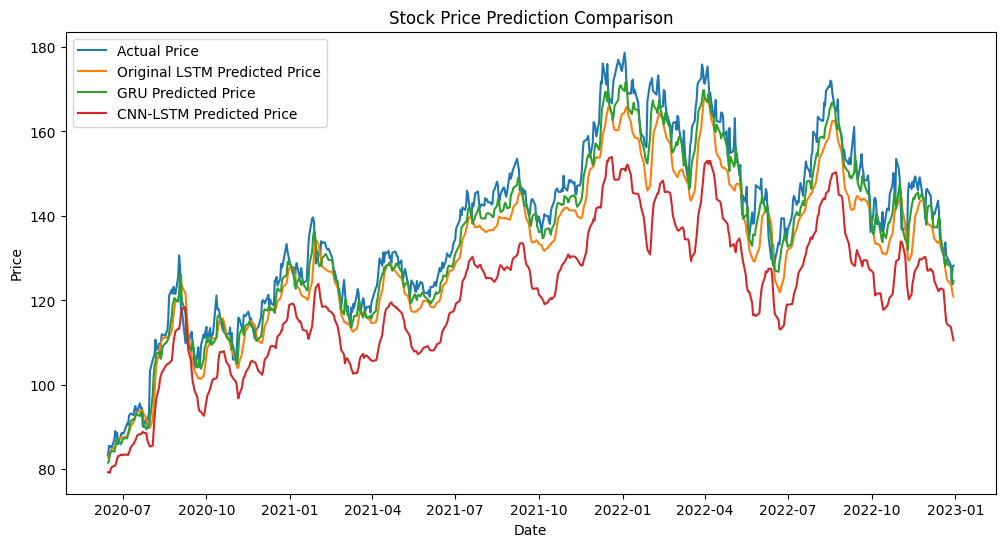

In [17]:
# Compare the evaluation metrics

print("Model Performance Comparison:")
print("-" * 40)

# Calculate Directional Accuracy for Original LSTM
lstm_actual_direction = np.sign(np.diff(y_test_original.flatten()))
lstm_predicted_direction = np.sign(np.diff(predictions.flatten()))
lstm_directional_accuracy = np.mean(lstm_actual_direction == lstm_predicted_direction) * 100

print(f"Original LSTM:")
print(f"  MSE: {mse}")
print(f"  RMSE: {rmse}")
print(f"  MAE: {mae}")
print(f"  Directional Accuracy: {lstm_directional_accuracy:.2f}%") # Added directional accuracy
print("-" * 40)

# Calculate Directional Accuracy for GRU Model
gru_actual_direction = np.sign(np.diff(y_test_original.flatten()))
gru_predicted_direction = np.sign(np.diff(gru_predictions.flatten()))
gru_directional_accuracy = np.mean(gru_actual_direction == gru_predicted_direction) * 100

print(f"GRU Model:")
print(f"  MSE: {gru_mse}")
print(f"  RMSE: {gru_rmse}")
print(f"  MAE: {gru_mae}")
print(f"  Directional Accuracy: {gru_directional_accuracy:.2f}%") # Added directional accuracy
print("-" * 40)

# Calculate Directional Accuracy for CNN-LSTM Hybrid Model
cnn_lstm_actual_direction = np.sign(np.diff(y_test_original.flatten()))
cnn_lstm_predicted_direction = np.sign(np.diff(cnn_lstm_predictions.flatten()))
cnn_lstm_directional_accuracy = np.mean(cnn_lstm_actual_direction == cnn_lstm_predicted_direction) * 100


print(f"CNN-LSTM Hybrid Model:")
print(f"  MSE: {cnn_lstm_mse}")
print(f"  RMSE: {cnn_lstm_rmse}")
print(f"  MAE: {cnn_lstm_mae}")
print(f"  Directional Accuracy: {cnn_lstm_directional_accuracy:.2f}%") # Added directional accuracy
print("-" * 40)

# Visualize predictions for all models
plt.figure(figsize=(12, 6))
plt.plot(test_data_index, y_test_original, label="Actual Price")
plt.plot(test_data_index, predictions, label="Original LSTM Predicted Price")
plt.plot(test_data_index, gru_predictions, label="GRU Predicted Price")
plt.plot(test_data_index, cnn_lstm_predictions, label="CNN-LSTM Predicted Price")
plt.title("Stock Price Prediction Comparison")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()